# Feature selection with null importances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind

# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings

warnings.filterwarnings("ignore")

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

%matplotlib inline

import warnings

warnings.simplefilter("ignore", UserWarning)
InteractiveShell.ast_node_interactivity = "all"
import sys

sys.path.append("../")
from helpers import *

In [3]:
if os.path.exists("../features_data/feature_matrix_final.csv"):
    feature_matrix_spec = pd.read_csv("../features_data/feature_matrix_final.csv")


feature_matrix_spec.head(10)
feature_matrix_spec = clean_feature_names(feature_matrix_spec)
feature_matrix_spec.replace([np.inf, -np.inf], np.nan, inplace=True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,SUM(credit.previous.DAYS_LAST_DUE),SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION),SUM(credit.previous.DAYS_TERMINATION),SUM(credit.previous.HOUR_APPR_PROCESS_START),SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL),SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY),SUM(credit.previous.RATE_DOWN_PAYMENT),SUM(credit.previous.RATE_INTEREST_PRIMARY),SUM(credit.previous.RATE_INTEREST_PRIVILEGED),SUM(credit.previous.SELLERPLACE_AREA)
0,100002,1,Cash loans,M,N,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,2191458.0,2191458.0,2191458.0,90.0,0.0,6.0,0.0,0.0,0.0,-6.0
4,100007,0,Cash loans,M,N,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100009,0,Cash loans,F,Y,171000.0,1560726.0,41301.0,1395000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,100010,0,Cash loans,M,Y,360000.0,1530000.0,42075.0,1530000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,112500.0,1019610.0,33826.5,913500.0,Children,...,-93018.0,27027982.0,27027982.0,740.0,0.0,74.0,0.0,0.0,0.0,0.0
9,100012,0,Revolving loans,M,N,135000.0,405000.0,20250.0,405000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data = feature_matrix_spec

categorical_feats = [
    f
    for f in data.columns
    if data[f].dtype == "object" or data[f].dtype.name == "category"
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype("category")


def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ["TARGET", "SK_ID_CURR"]]
    # Go over fold and keep track of CV score (train and valid) and feature importances

    # Shuffle target if required
    y = data["TARGET"].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data["TARGET"].copy().sample(frac=1.0)

    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False)
    lgb_params = {
        "objective": "binary",
        "boosting_type": "rf",
        "subsample": 0.623,
        "colsample_bytree": 0.7,
        "num_leaves": 127,
        "max_depth": 8,
        "seed": seed,
        "bagging_freq": 1,
        "n_jobs": -1,
    }

    # Fit the model
    clf = lgb.train(
        params=lgb_params,
        train_set=dtrain,
        num_boost_round=200,
        categorical_feature=categorical_feats,
    )

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type="gain")
    imp_df["importance_split"] = clf.feature_importance(importance_type="split")
    # imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]), multi_class='ovr')
    return imp_df


# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)
actual_imp_df.head()
null_imp_df = pd.DataFrame()
nb_runs = 50
import time

start = time.time()
dsp = ""
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df["run"] = i + 1
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print("\b", end="", flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = "Done with %4d of %4d (Spent %5.1f min)" % (i + 1, nb_runs, spent)
    print(dsp, end="", flush=True)

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'WALLSMATERIAL_MODE',
 'prev_PRODUCT_COMBINATION']

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.934777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 290776
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 1501
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


,feature,importance_gain,importance_split
0,NAME_CONTRACT_TYPE,282.746096,6
1,CODE_GENDER,4887.967188,89
2,FLAG_OWN_CAR,149.629799,4
3,AMT_INCOME_TOTAL,938.896204,23
4,AMT_CREDIT,5376.895796,102


[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.925903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 290776
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 1501
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [5]:
null_imp_df.to_csv("../importances/null_importances_distribution_rf_final.csv")
actual_imp_df.to_csv("../importances/actual_importances_ditribution_rf_final.csv")

In [9]:
null_imp_df = pd.read_csv("../importances/null_importances_distribution_rf_final.csv")
# drop unnamed column
null_imp_df.drop(null_imp_df.columns[0], axis=1, inplace=True)
actual_imp_df = pd.read_csv(
    "../importances/actual_importances_ditribution_rf_final.csv"
)
actual_imp_df.drop(actual_imp_df.columns[0], axis=1, inplace=True)

null_imp_df.head()
actual_imp_df.head()

,feature,importance_gain,importance_split,run
0,NAME_CONTRACT_TYPE,0.000000,0,1
1,CODE_GENDER,15.826296,20,1
2,FLAG_OWN_CAR,14.396300,10,1
3,AMT_INCOME_TOTAL,726.291291,101,1
4,AMT_CREDIT,1046.419406,113,1


,feature,importance_gain,importance_split
0,NAME_CONTRACT_TYPE,282.746096,6
1,CODE_GENDER,4887.967188,89
2,FLAG_OWN_CAR,149.629799,4
3,AMT_INCOME_TOTAL,938.896204,23
4,AMT_CREDIT,5376.895796,102


In [10]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(
        null_imp_df_.loc[
            null_imp_df_["feature"] == feature_, "importance_split"
        ].values,
        label="Null importances",
    )
    ax.vlines(
        x=actual_imp_df_.loc[
            actual_imp_df_["feature"] == feature_, "importance_split"
        ].mean(),
        ymin=0,
        ymax=np.max(a[0]),
        color="r",
        linewidth=10,
        label="Real Target",
    )
    ax.legend()
    ax.set_title("Split Importance of %s" % feature_.upper(), fontweight="bold")
    plt.xlabel("Null Importance (split) Distribution for %s " % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(
        null_imp_df_.loc[null_imp_df_["feature"] == feature_, "importance_gain"].values,
        label="Null importances",
    )
    ax.vlines(
        x=actual_imp_df_.loc[
            actual_imp_df_["feature"] == feature_, "importance_gain"
        ].mean(),
        ymin=0,
        ymax=np.max(a[0]),
        color="r",
        linewidth=10,
        label="Real Target",
    )
    ax.legend()
    ax.set_title("Gain Importance of %s" % feature_.upper(), fontweight="bold")
    plt.xlabel("Null Importance (gain) Distribution for %s " % feature_.upper())

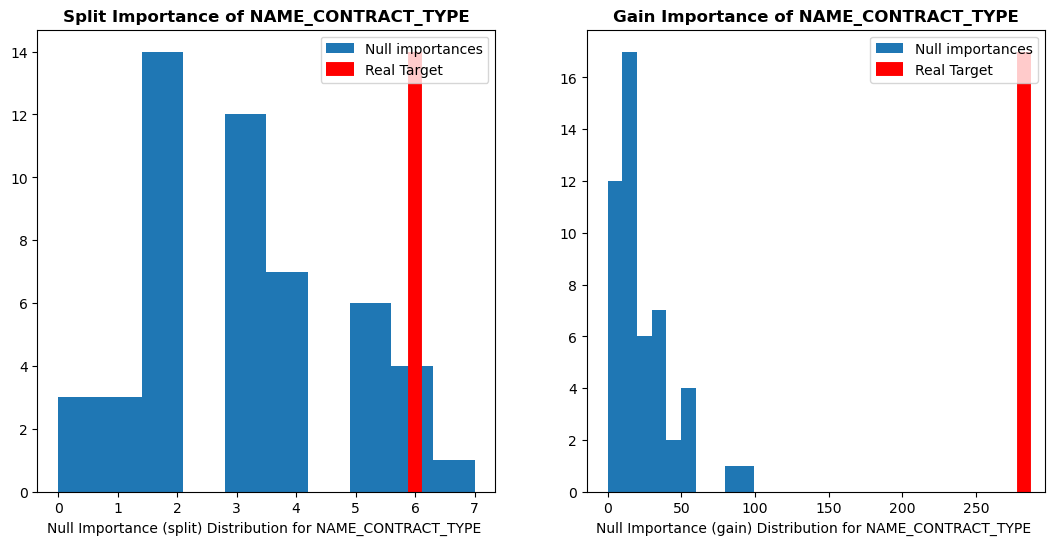

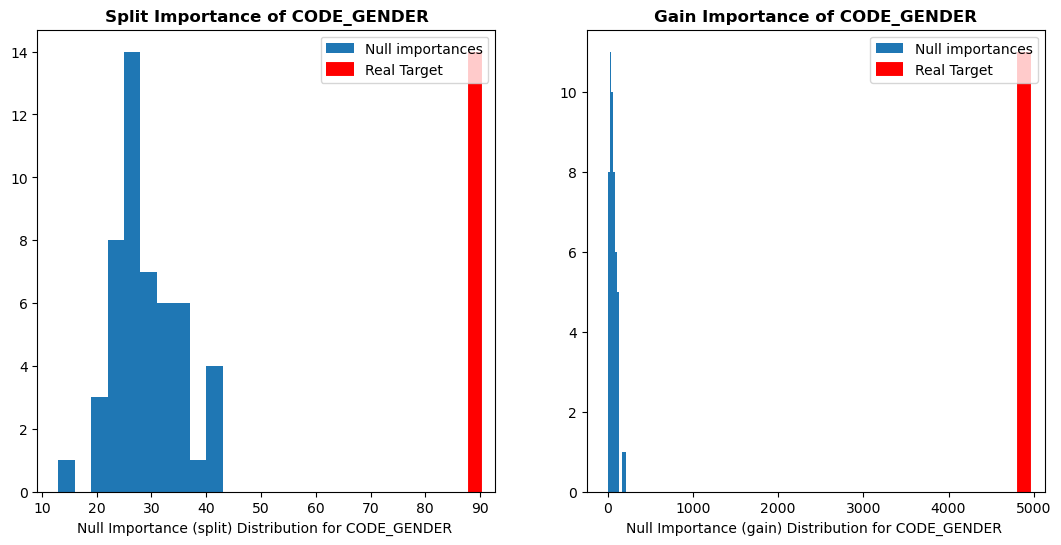

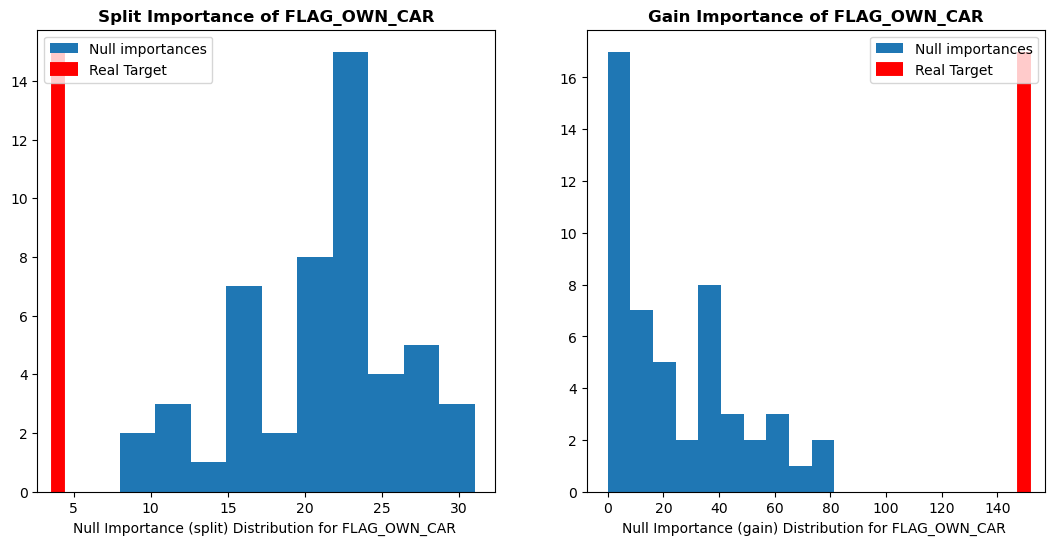

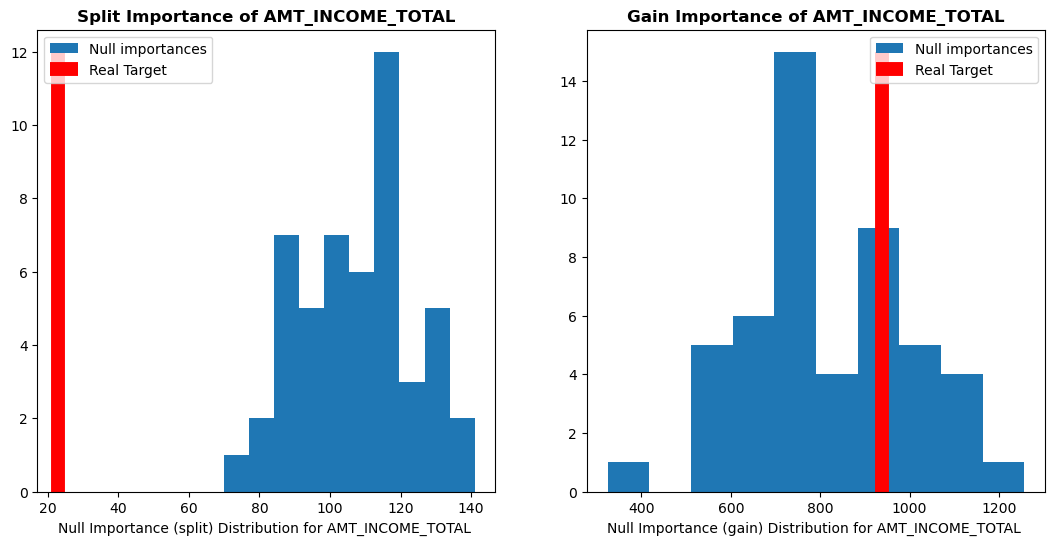

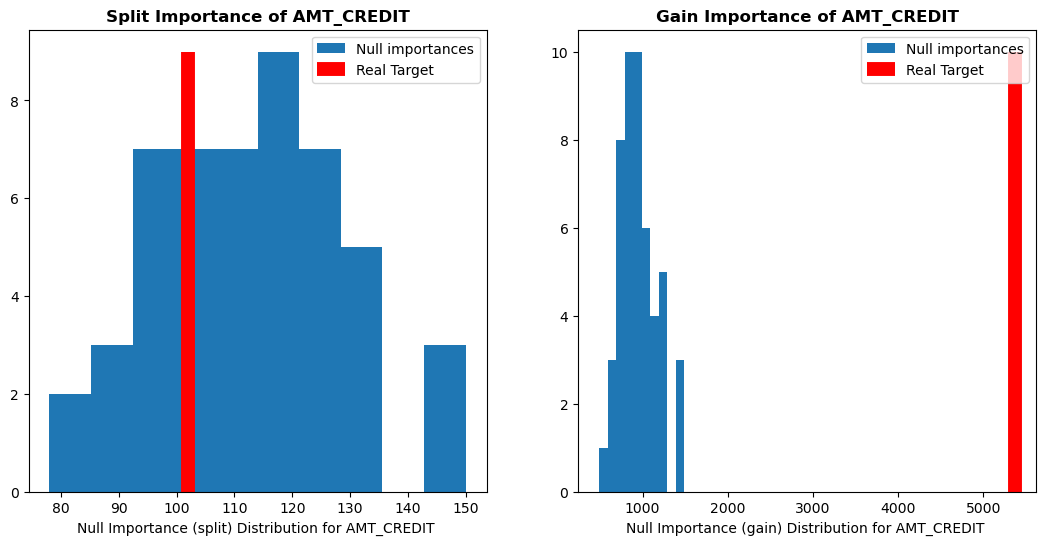

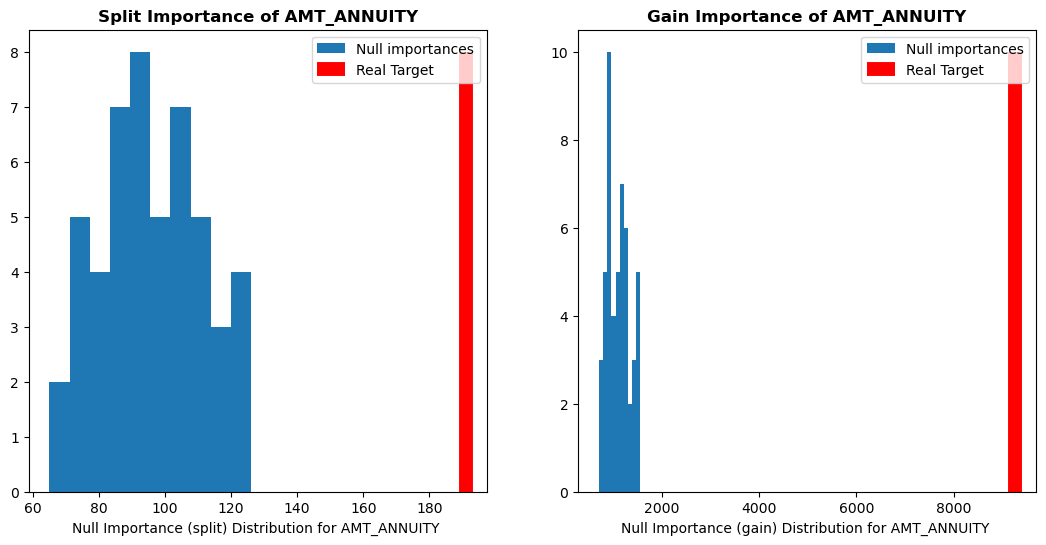

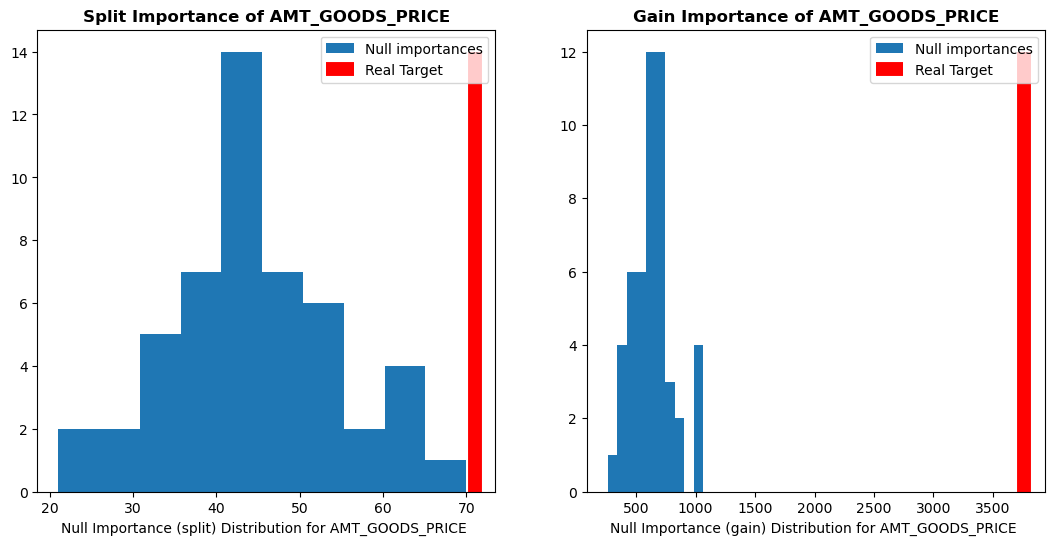

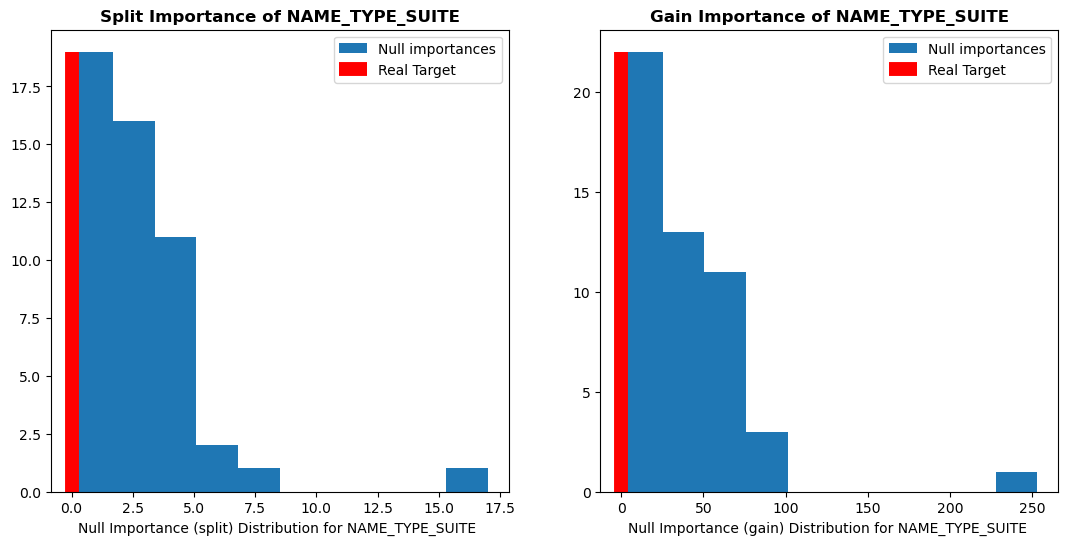

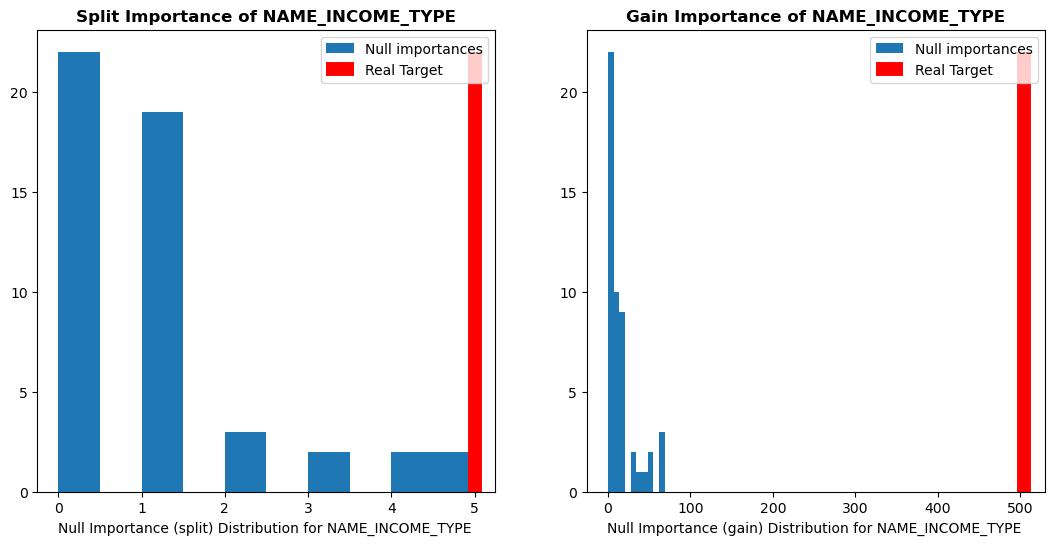

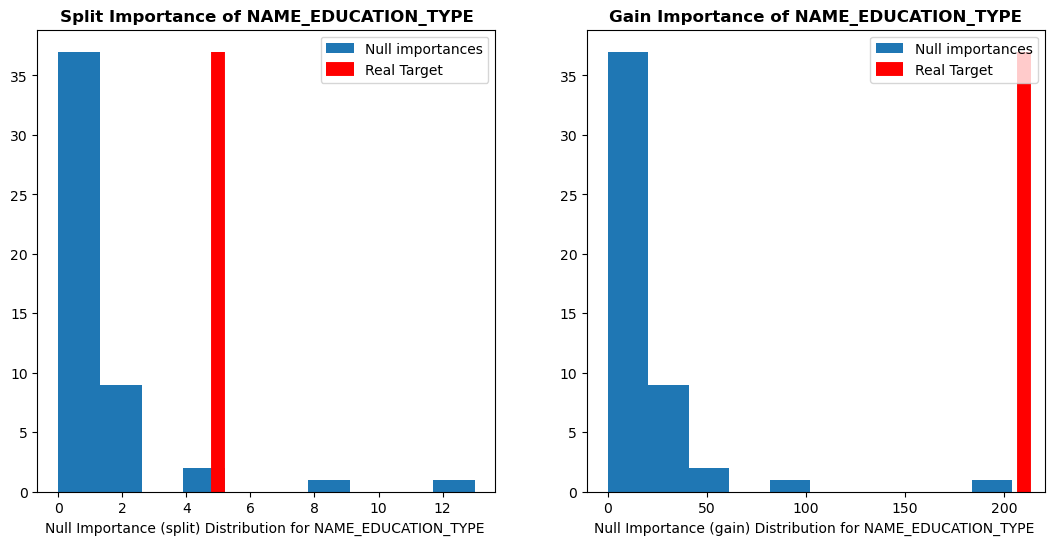

In [11]:
for feature in null_imp_df.feature[:10]:
    display_distributions(
        actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=feature
    )

### Best features

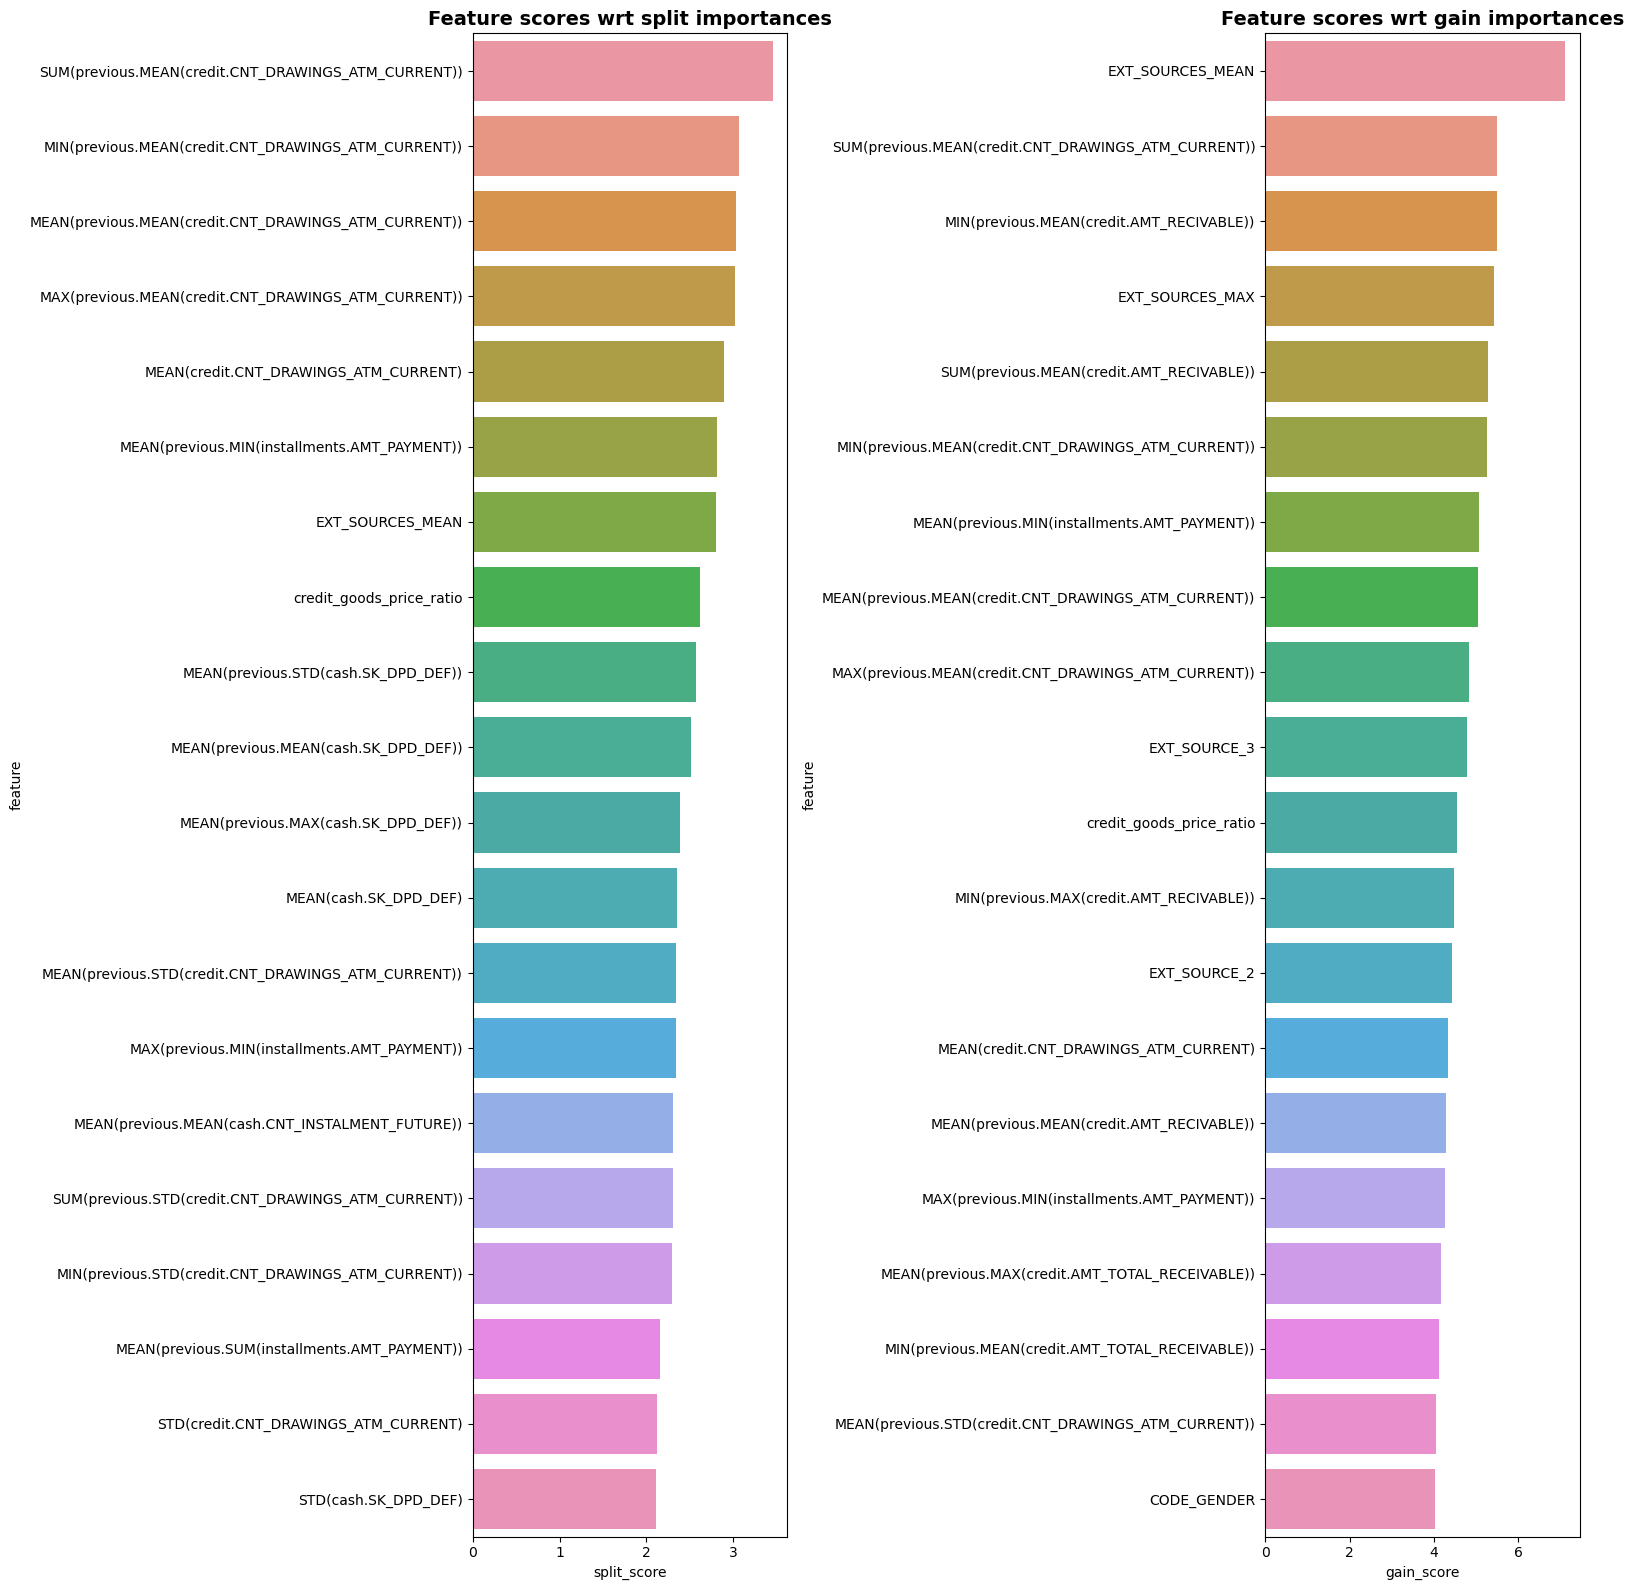

In [12]:
feature_scores = []
for _f in actual_imp_df["feature"].unique():
    f_null_imps_gain = null_imp_df.loc[
        null_imp_df["feature"] == _f, "importance_gain"
    ].values
    f_act_imps_gain = actual_imp_df.loc[
        actual_imp_df["feature"] == _f, "importance_gain"
    ].mean()
    if f_null_imps_gain.size > 0:
        gain_score = np.log(
            1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75))
        )  # Avoid divide by zero
    else:
        gain_score = -1

    f_null_imps_split = null_imp_df.loc[
        null_imp_df["feature"] == _f, "importance_split"
    ].values
    f_act_imps_split = actual_imp_df.loc[
        actual_imp_df["feature"] == _f, "importance_split"
    ].mean()
    if f_null_imps_split.size > 0:
        split_score = np.log(
            1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75))
        )  # Avoid divide by zero
    else:
        split_score = -1

    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(
    feature_scores, columns=["feature", "split_score", "gain_score"]
)

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(
    x="split_score",
    y="feature",
    data=scores_df.sort_values("split_score", ascending=False).iloc[0:20],
    ax=ax,
)
ax.set_title("Feature scores wrt split importances", fontweight="bold", fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(
    x="gain_score",
    y="feature",
    data=scores_df.sort_values("gain_score", ascending=False).iloc[0:20],
    ax=ax,
)
ax.set_title("Feature scores wrt gain importances", fontweight="bold", fontsize=14)
plt.tight_layout();

### Worst features

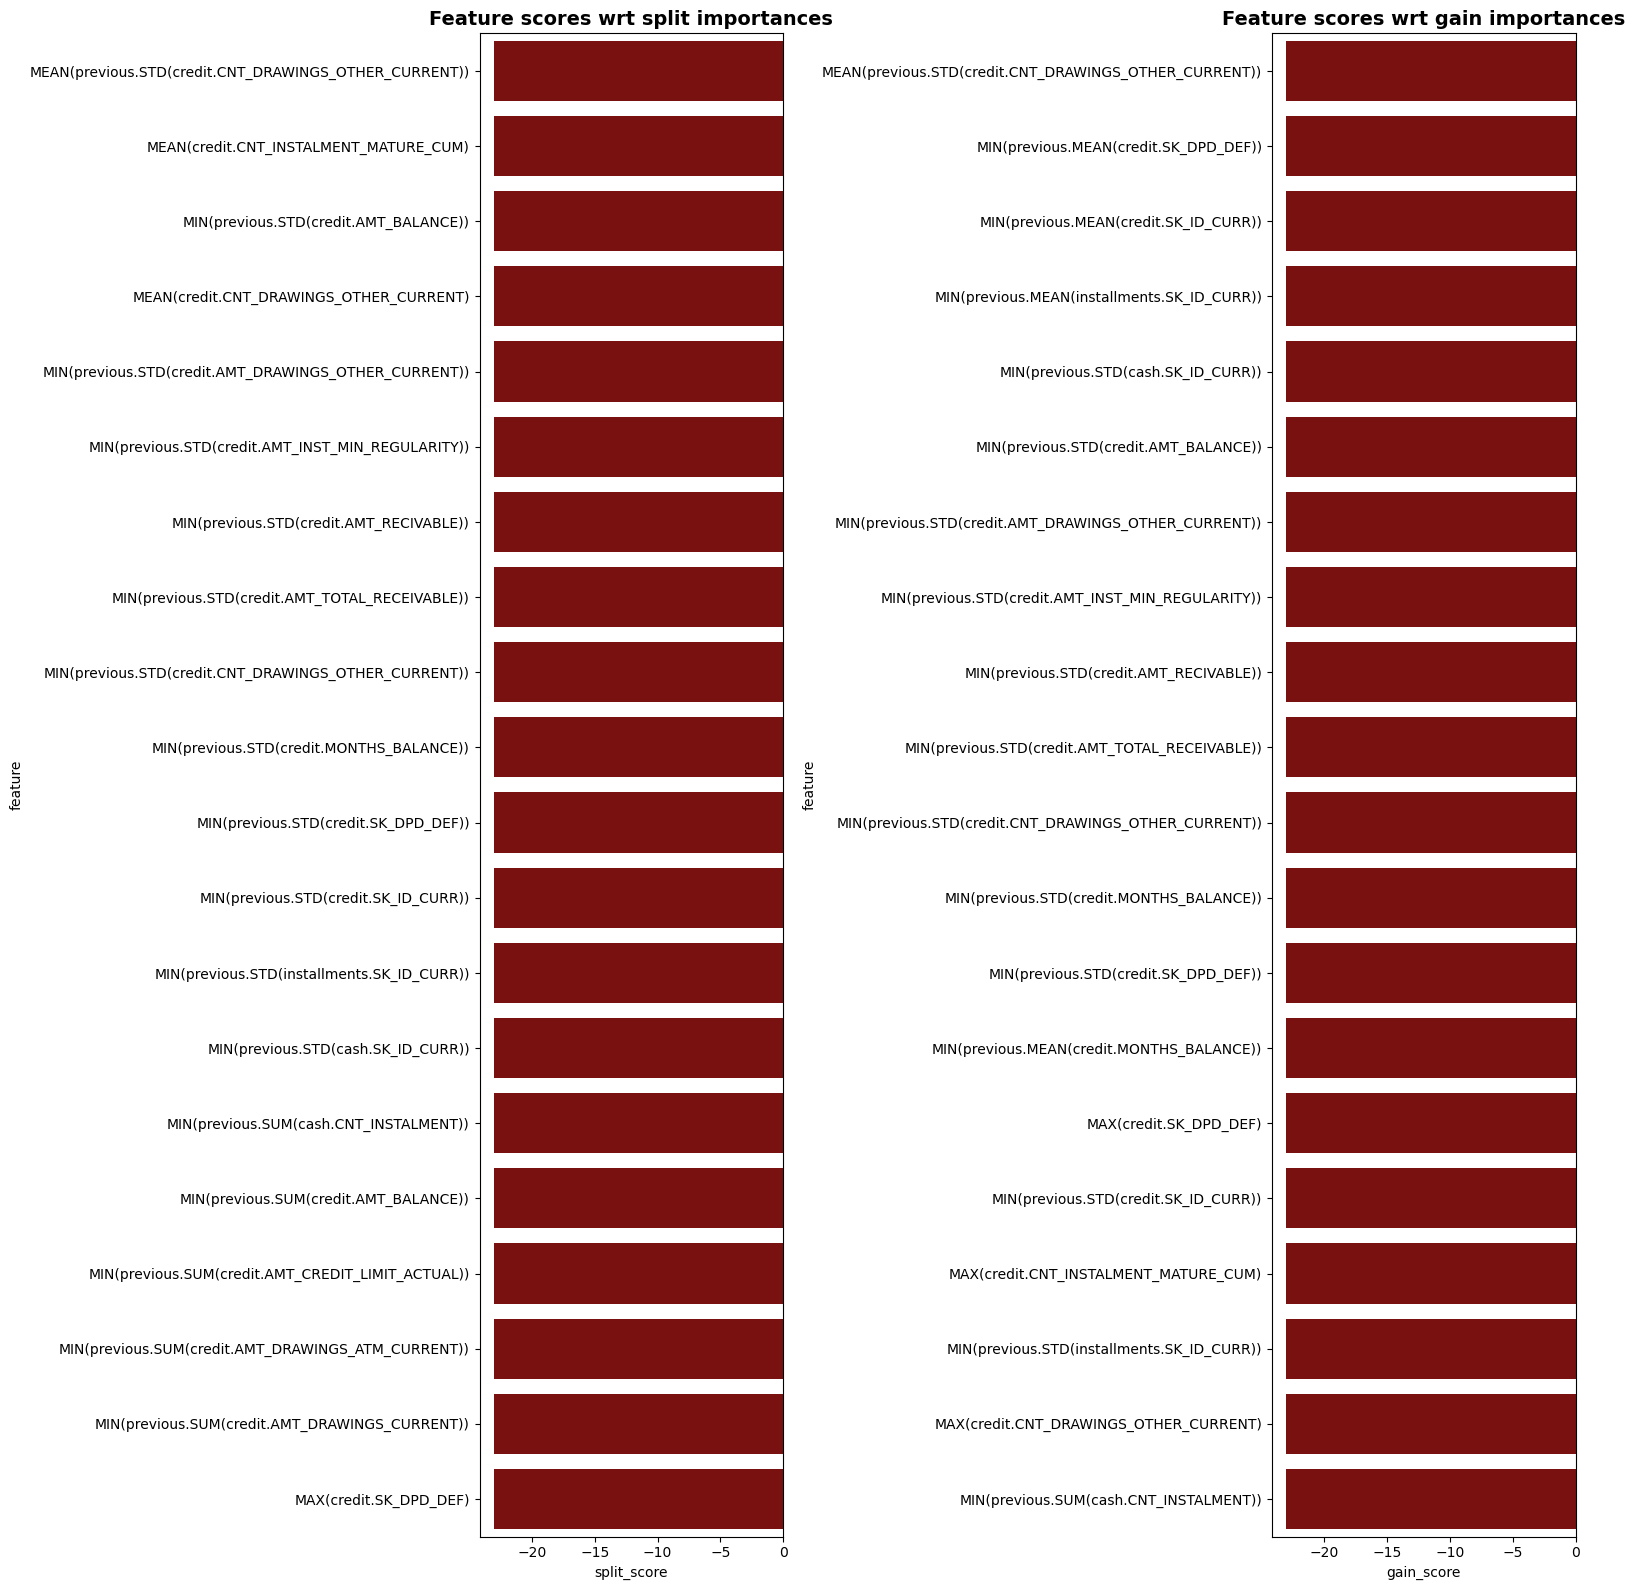

In [13]:
plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(
    x="split_score",
    y="feature",
    data=scores_df.sort_values("split_score", ascending=True).iloc[0:20],
    ax=ax,
    color="darkred",
)
ax.set_title("Feature scores wrt split importances", fontweight="bold", fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(
    x="gain_score",
    y="feature",
    data=scores_df.sort_values("gain_score", ascending=True).iloc[0:20],
    ax=ax,
    color="darkred",
)
ax.set_title("Feature scores wrt gain importances", fontweight="bold", fontsize=14)
plt.tight_layout();

### Removing useless features

In [15]:
split_score_threshold = 0
gain_score_threshold = 0

# Filter features based on thresholds
useful_features = scores_df[
    (scores_df["split_score"] > split_score_threshold)
    & (scores_df["gain_score"] > gain_score_threshold)
]

len(useful_features)

# remove keep only useful features from feature matrix
feature_matrix_spec_testing = feature_matrix_spec[
    ["TARGET"] + useful_features.feature.to_list()
]

423

#### Data preparation

In [18]:
from sklearn.model_selection import train_test_split

dummied_feature_matrix = pd.get_dummies(feature_matrix_spec_testing)
len(dummied_feature_matrix.columns)
features = dummied_feature_matrix
# Only numeric features
features = features.select_dtypes("number")

# Extract the labels
labels = np.array(features["TARGET"].astype(np.int32)).reshape((-1,))
# features = features.drop(columns = ['TARGET'])

# filter features to only include top features
features = features[dummied_feature_matrix.columns.to_list()]

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=42
)

# Separate features and target for the training data
X_train = train_features.drop(columns=["TARGET"])
y_train = train_features["TARGET"]

# Separate features and target for the testing data
X_test = test_features.drop(columns=["TARGET"])
y_test = test_features["TARGET"]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_test = clean_feature_names(X_test)

# Replace infinite values with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Final Train shape: ", X_train.shape)
print("Final Test shape: ", X_test.shape)

513

Final Train shape:  (230633, 512)
Final Test shape:  (76878, 512)


In [19]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize and train the model
model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", verbosity=0, tree_method="gpu_hist"
)
model.fit(X_train_imputed, y_train)

# Predict probabilities and calculate AUC
y_pred_proba = model.predict_proba(X_test_imputed)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
auc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

0.7708743661102423

- -inf: 0.7701896435261568
- -5: 0.7708221453890551
- -4: 0.7708221453890551
- -3: 0.7703850067899848
- -2: 0.7711743102057587
- -1: 0.7709733827947249
-  0: 0.7713115584084744
-  1: 0.7579215215631486
-  2: 0.7087799366001187

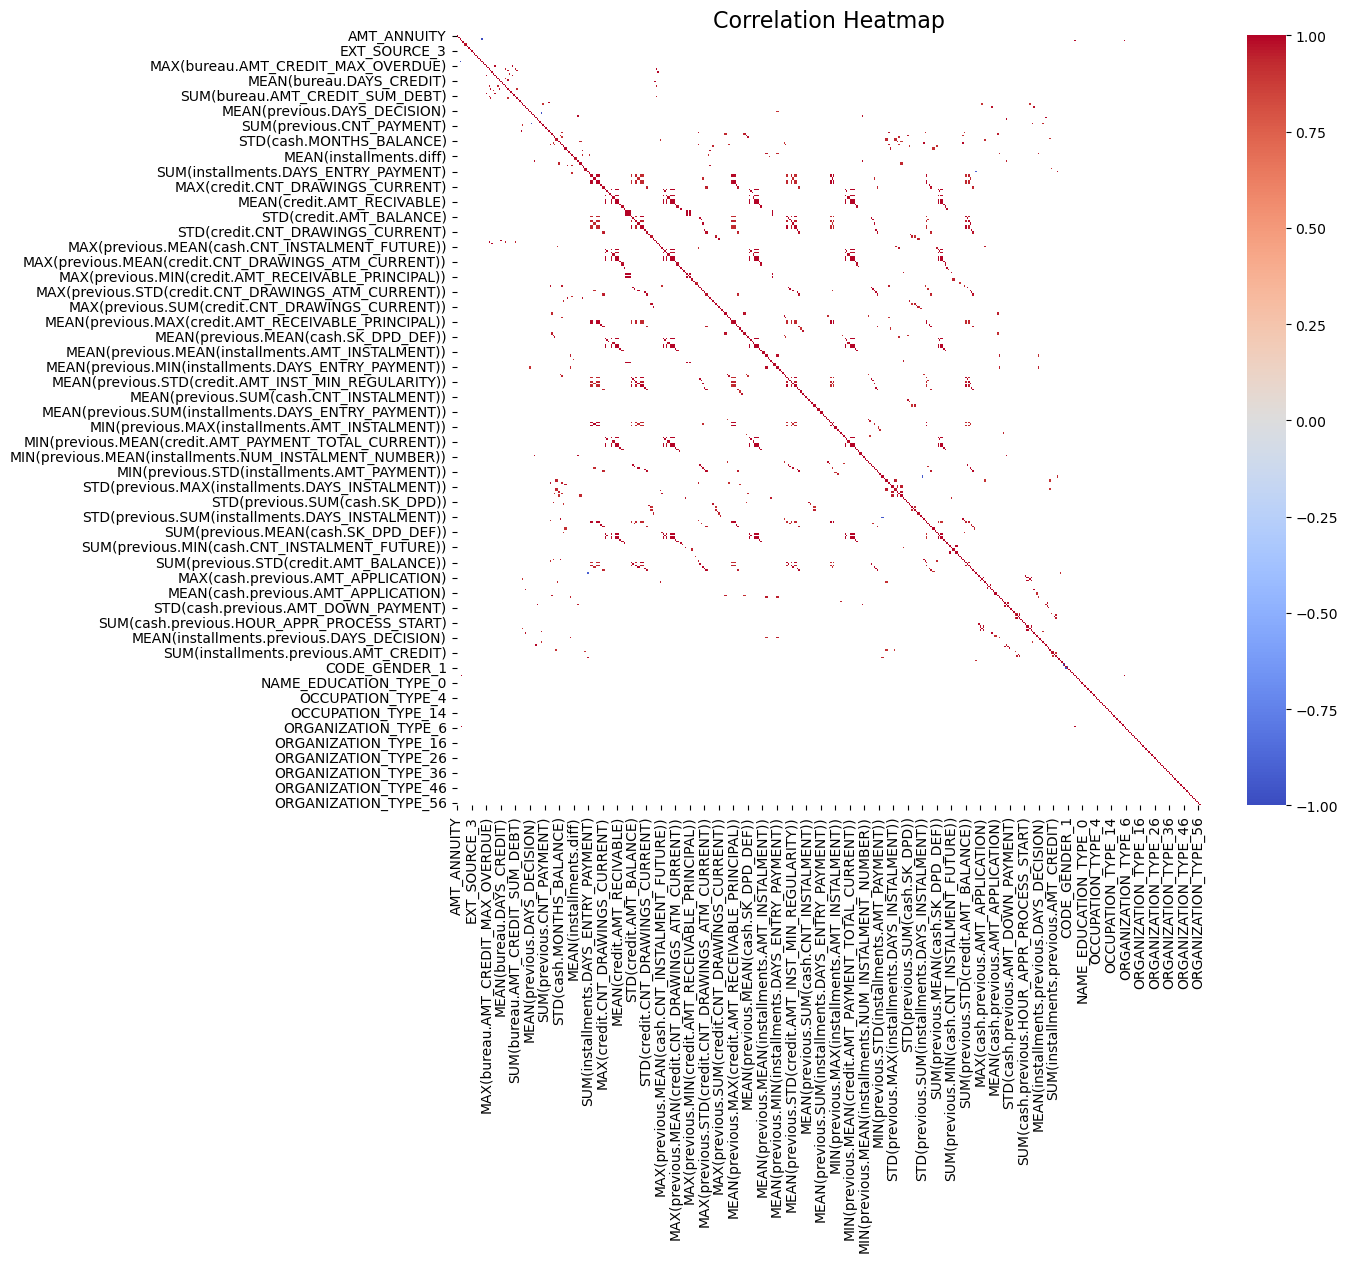

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the correlation matrix
corr = X_train.corr()

# Create a mask to display only correlations above a certain threshold
mask = corr.abs() <= 0.9

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=False)
plt.title("Correlation Heatmap", fontsize=16)
plt.show();

In [21]:
def remove_highly_correlated_features(X, threshold=0.9):
    # Create correlation matrix
    corr_matrix = X.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    return to_drop


# Identify the features to drop from the training set
features_to_drop = remove_highly_correlated_features(X_train, threshold=0.9)

# Drop the features from the training set
X_train_reduced = X_train.drop(columns=features_to_drop)

# Drop the same features from the test set
X_test_reduced = X_test.drop(columns=features_to_drop)

print("Reduced training set shape:", X_train_reduced.shape)
print("Reduced test set shape:", X_test_reduced.shape)

Reduced training set shape: (230633, 265)
Reduced test set shape: (76878, 265)


In [22]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Initialize and train the model
model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", verbosity=0, tree_method="gpu_hist"
)
model.fit(X_train_imputed, y_train)

# Predict probabilities and calculate AUC
y_pred_proba = model.predict_proba(X_test_imputed)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
auc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

0.7708743661102423

Percentage of features dropped after removing highly correlated features

In [23]:
len(features_to_drop) / X_train.shape[1] * 100

48.2421875

In [24]:
# save train and test to disk
X_train.to_csv("../training_data/X_train.csv", index=False)
y_train.to_csv("../training_data/y_train.csv", index=False)
X_test.to_csv("../training_data/X_test.csv", index=False)
y_test.to_csv("../training_data/y_test.csv", index=False)

<Figure size 1600x600 with 0 Axes>

<Axes: >

(array([476.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   8.,  26.,  70., 157., 263., 232.,
        148.,  60.,  52.,  19.,   6.,   4.]),
 array([-23.02585093, -22.49633416, -21.96681739, -21.43730062,
        -20.90778385, -20.37826708, -19.84875031, -19.31923354,
        -18.78971677, -18.2602    , -17.73068323, -17.20116647,
        -16.6716497 , -16.14213293, -15.61261616, -15.08309939,
        -14.55358262, -14.02406585, -13.49454908, -12.96503231,
        -12.43551554, -11.90599877, -11.376482  , -10.84696523,
        -10.31744846,  -9.78793169,  -9.25841492,  -8.72889815,
         -8.19938138,  -7.66986461,  -7.14034784,  -6.61083107,
         -6.08131431,  -5.55179754,  -5.02228077,  -4.492764  ,
         -3.96324723,  -3.43373046,  -2.90421369,  -2.37469692,
         -1.845180

Text(0.5, 1.0, 'Distribution of split scores')

<Axes: >

(array([476.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  12.,  34.,  73., 241., 287., 179.,  94.,  51.,  34.,
         22.,   8.,   6.,   3.,   0.,   1.]),
 array([-23.02585093, -22.42323605, -21.82062117, -21.2180063 ,
        -20.61539142, -20.01277654, -19.41016166, -18.80754679,
        -18.20493191, -17.60231703, -16.99970215, -16.39708728,
        -15.7944724 , -15.19185752, -14.58924264, -13.98662777,
        -13.38401289, -12.78139801, -12.17878313, -11.57616826,
        -10.97355338, -10.3709385 ,  -9.76832362,  -9.16570874,
         -8.56309387,  -7.96047899,  -7.35786411,  -6.75524923,
         -6.15263436,  -5.55001948,  -4.9474046 ,  -4.34478972,
         -3.74217485,  -3.13955997,  -2.53694509,  -1.93433021,
         -1.33171534,  -0.72910046,  -0.12648558,   0.4761293 ,
          1.078744

Text(0.5, 1.0, 'Distribution of gain scores')

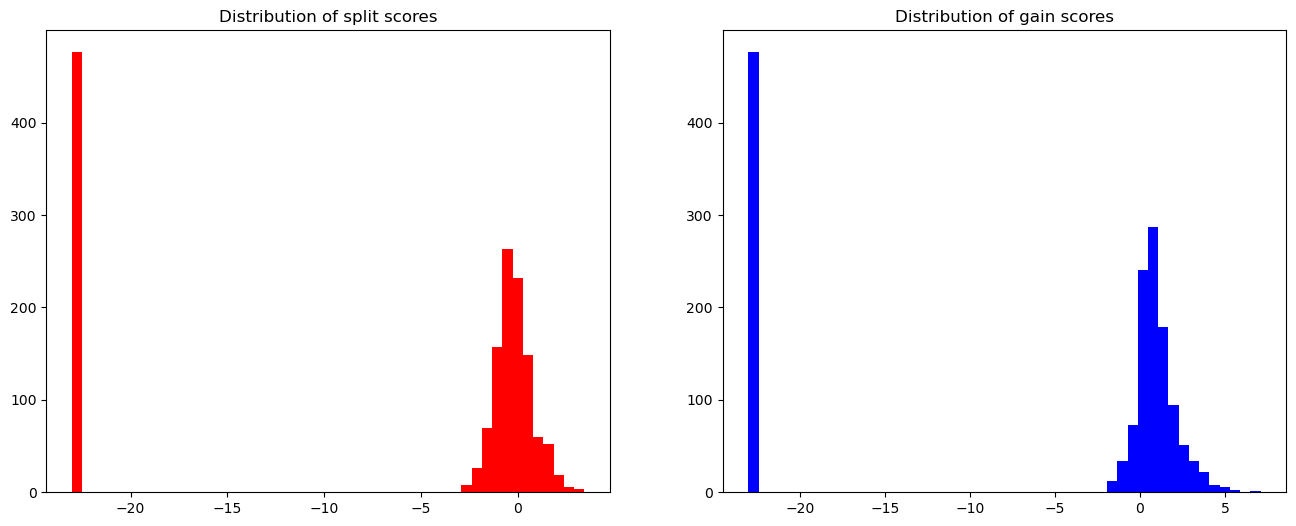

In [25]:
# plot the distribution of both split and gain scores
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.hist(scores_df["split_score"], bins=50, color="r")
plt.title("Distribution of split scores")

plt.subplot(1, 2, 2)
plt.hist(scores_df["gain_score"], bins=50, color="b")
plt.title("Distribution of gain scores")
plt.show()

LGBMClassifier()

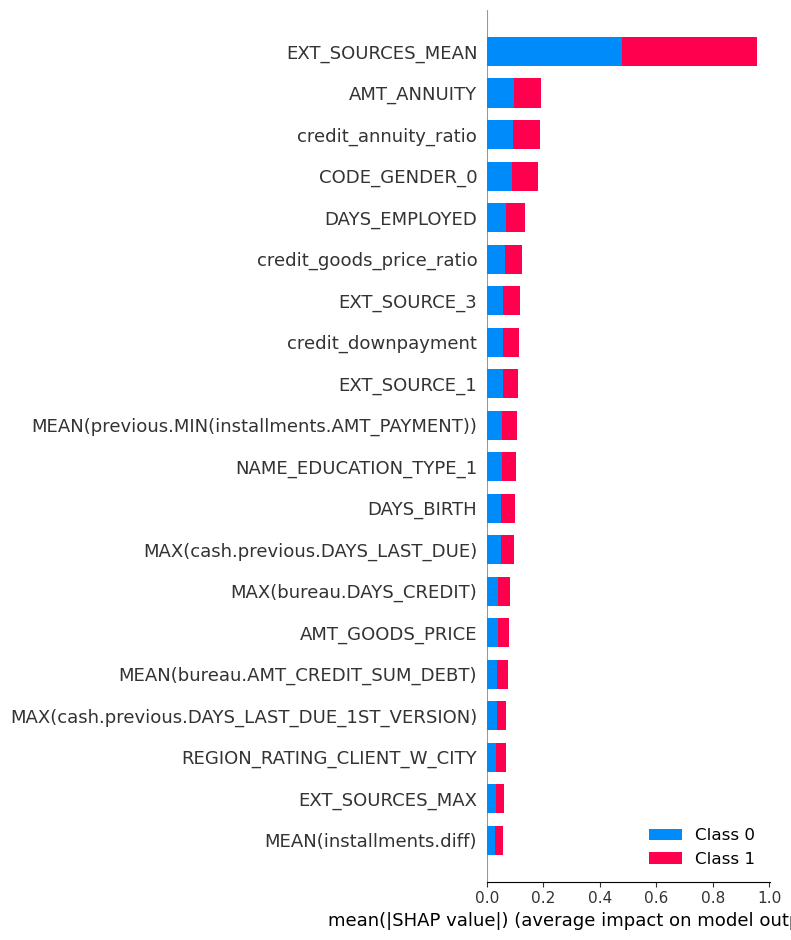

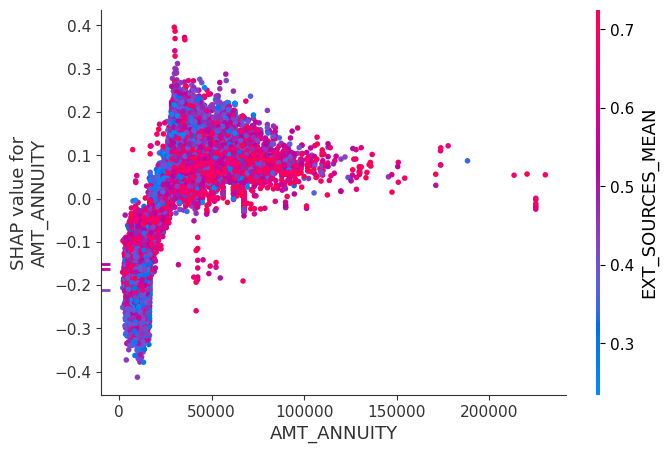

In [26]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# Train a LightGBM model
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# Create the SHAP Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Plot the SHAP values for the first prediction
shap.initjs()  # Initialize JavaScript visualization in Jupyter Notebook
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], X_test.iloc[0, :])

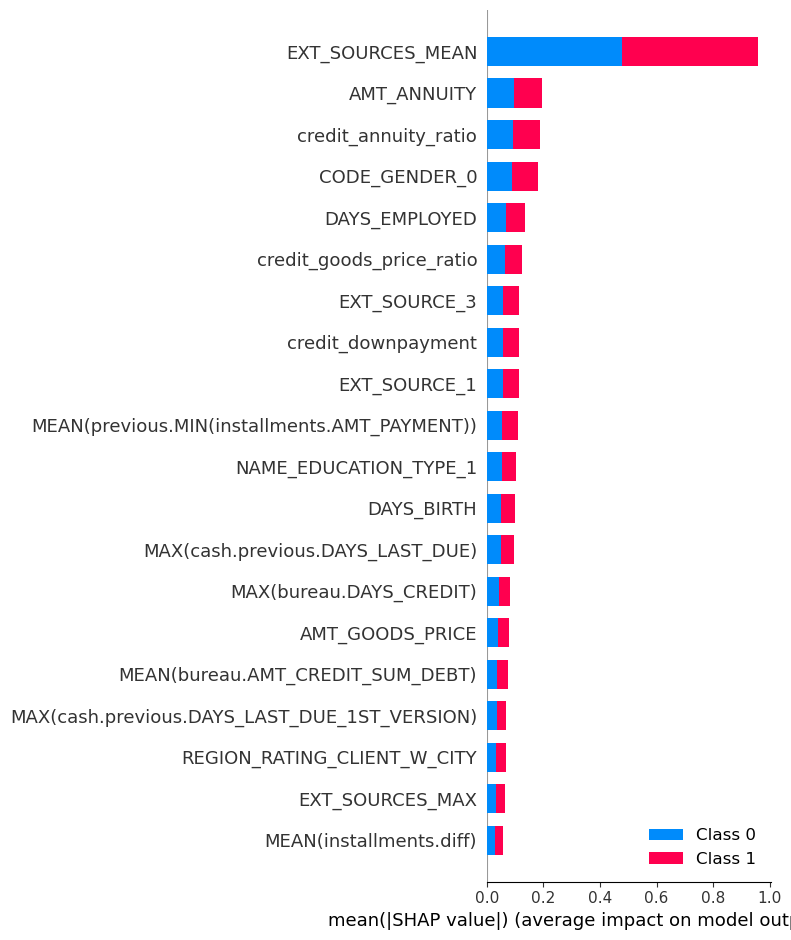

In [27]:
import shap
import matplotlib.pyplot as plt

# Assuming your model is already trained and is named 'model'
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Summarize the SHAP values in a bar plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

<Figure size 1000x3000 with 0 Axes>

<BarContainer object of 100 artists>

<BarContainer object of 100 artists>

Text(0.5, 0, 'mean(|SHAP value|) (average impact on model output magnitude)')

Text(0.5, 1.0, 'Top SHAP values across all classes')

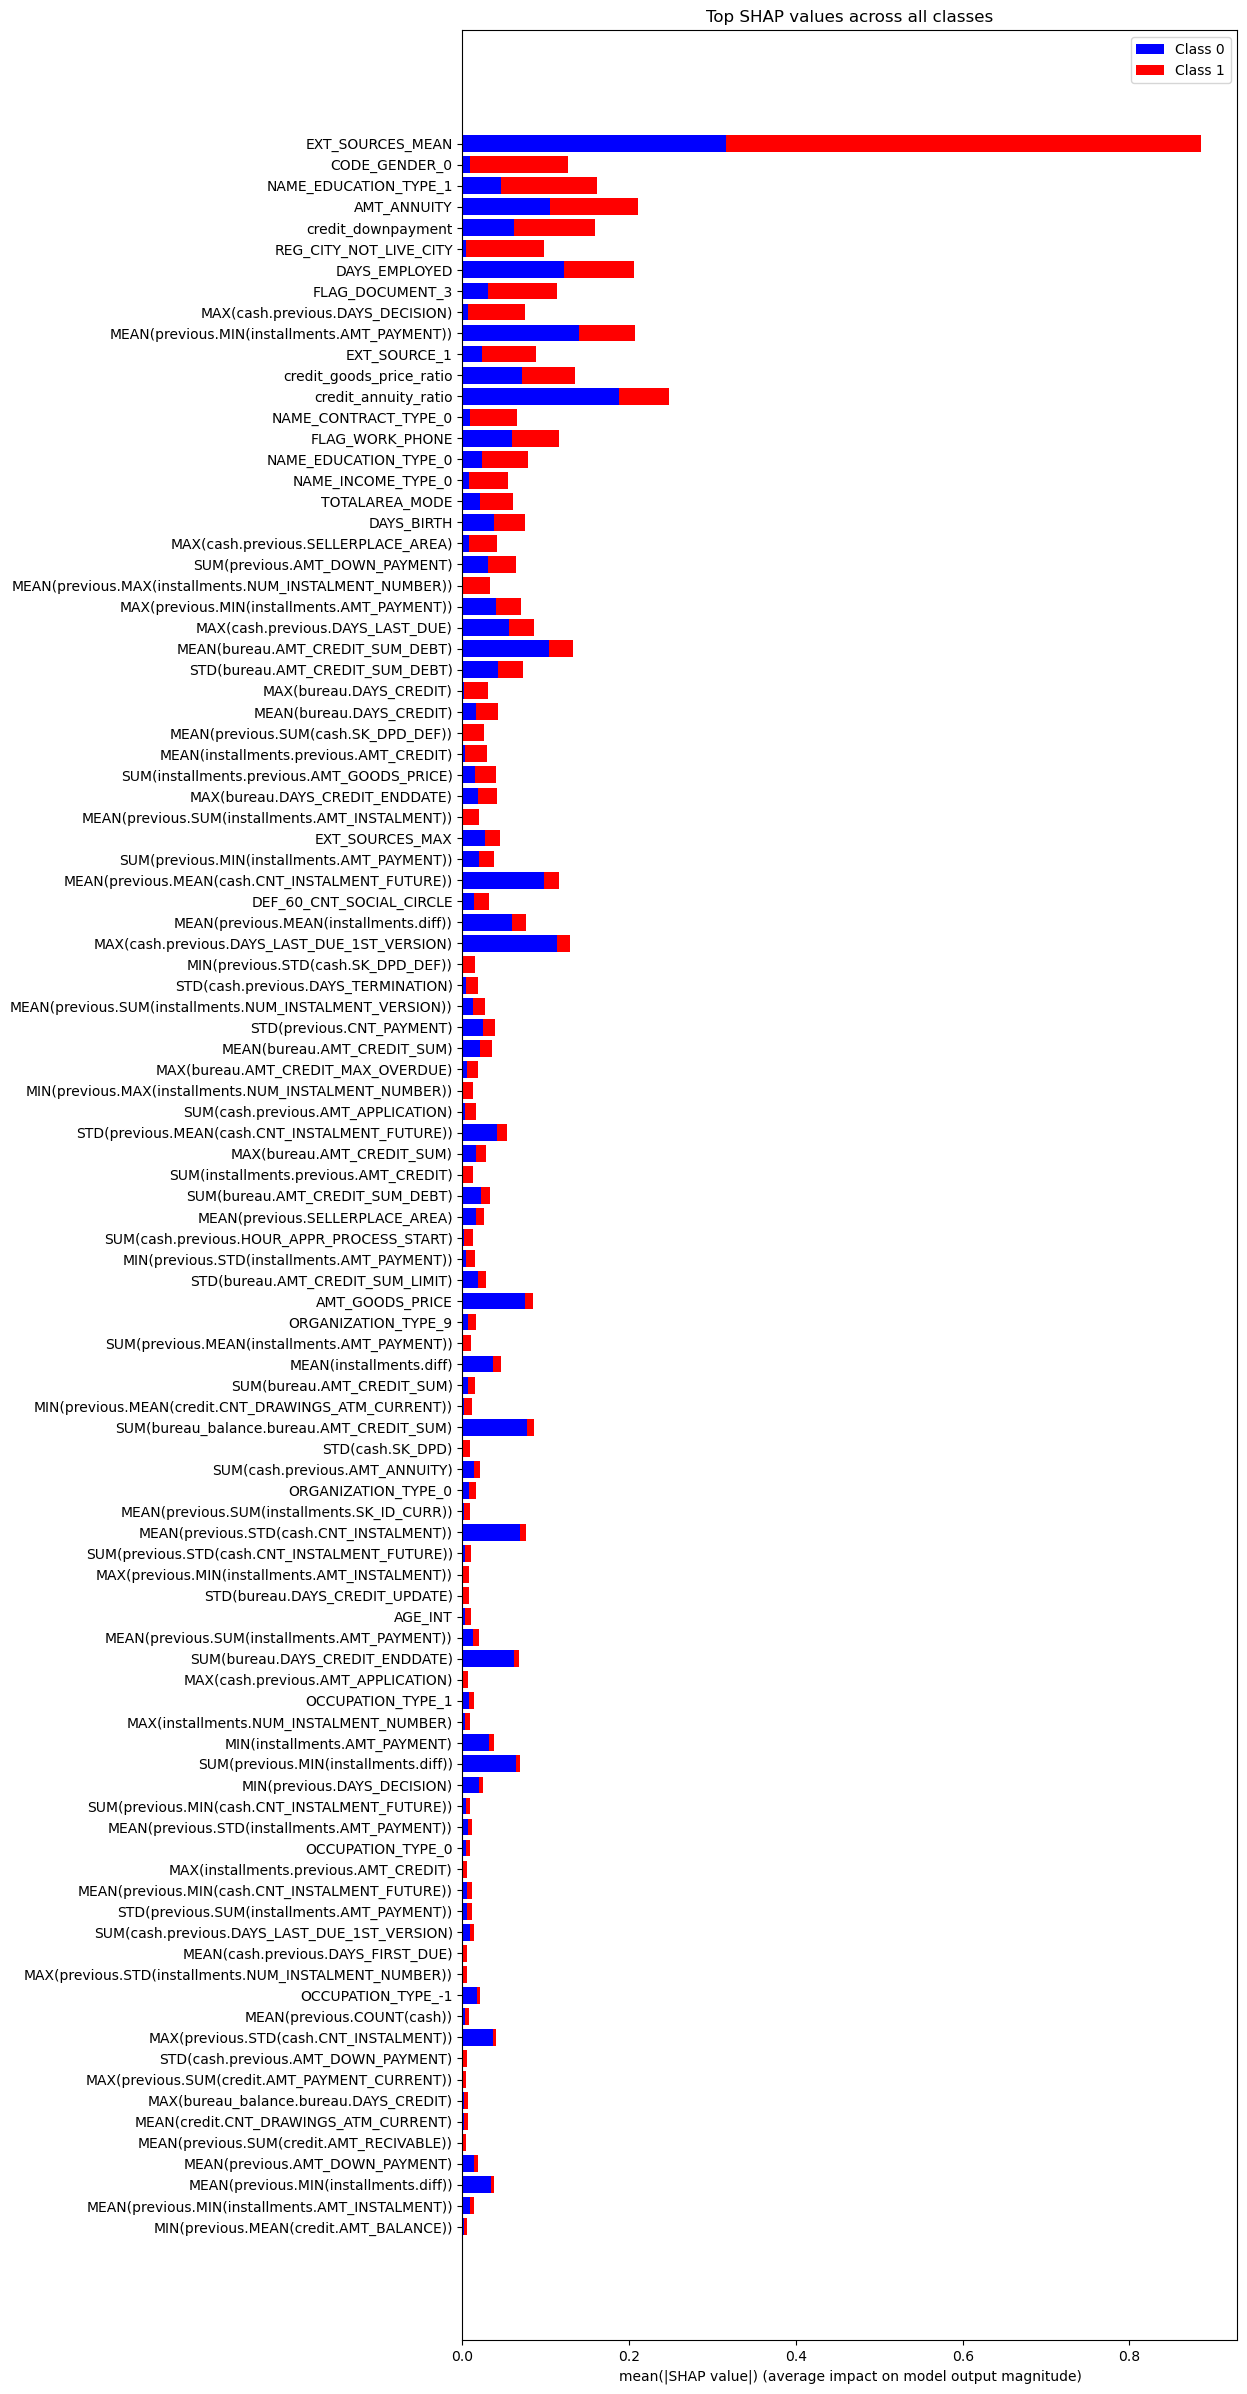

In [28]:
import numpy as np

# Calculate the mean absolute SHAP values for each feature for each class
shap_sum = np.abs(shap_values).mean(axis=0)
feature_names = X_train.columns
class_inds = np.argsort(shap_sum[1])[::-1]
class_0_values = shap_sum[0][class_inds]
class_1_values = shap_sum[1][class_inds]
features = np.array(feature_names)[class_inds]

n = 100
plt.figure(figsize=(10, 30))
plt.barh(features[:n], class_0_values[:n], color="blue", label="Class 0")
plt.barh(
    features[:n],
    class_1_values[:n],
    color="red",
    label="Class 1",
    left=class_0_values[:n],
)
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)")
plt.title("Top SHAP values across all classes")
plt.legend()
plt.gca().invert_yaxis()  # To display the highest values at the top
plt.show()
# sort the features by the magnitude of their SHAP values for both classes